In [8]:
using Distributed
# addprocs(4)

@everywhere begin
    using Revise
    using MendelIHT
    using SnpArrays
    using Random
    using GLM
    using DelimitedFiles
    using Test
    using Distributions
    using LinearAlgebra
    using CSV
    using DataFrames
    using StatsBase
    using TraitSimulation, OrdinalMultinomialModels, VarianceComponentModels
end

using Plots

## Univariate Normal: does cross validation works?

In [6]:
n = 1000  # number of samples
p = 10000 # number of SNPs
k = 10    # number of causal SNPs per trait
d = Normal
l = canonicallink(d())

# set random seed for reproducibility
Random.seed!(2021)

repeats = 50
best_k = zeros(repeats)

for i in 1:repeats
    println("$i th repeat")
    
    # simulate `.bed` file with no missing data
    x = simulate_random_snparray(undef, n, p)
    xla = SnpLinAlg{Float64}(x, model=ADDITIVE_MODEL, center=true, scale=true) 
    # xla = randn(n, p)

    # intercept is the only nongenetic covariate
    z = ones(n)
    intercept = 1.0

    # simulate response y, true model b, and the correct non-0 positions of b
    Y, true_b, correct_position = simulate_random_response(xla, k, d, l, Zu=z*intercept);

    # 4 cores
    @time mses = cv_iht(Y, xla, z, d=d(), l=l, parallel=true);
    best_k[i] = argmin(mses)
end



Crossvalidation Results:
	k	MSE
	1	1198.8402606448158
	2	849.0864578174054
	3	637.1443395378783
	4	489.42904203198214
	5	392.64715981591604
	6	305.76463022134374
	7	265.84295854349904
	8	241.79398508750788
	9	239.6530326044807
	10	246.50386015072223
	11	246.86721719258918
	12	250.93496279600697
	13	256.4945027972453
	14	261.41904033200643
	15	261.50686004977985
	16	263.5390287019001
	17	259.68101704677997
	18	264.1591652784002
	19	267.221937492214
	20	267.5761892434861

Best k = 9

 22.151859 seconds (3.13 M allocations: 164.865 MiB, 0.20% gc time)


Crossvalidation Results:
	k	MSE
	1	1325.1652748951292
	2	1124.685871700383
	3	963.4630813716803
	4	752.2507433791473
	5	550.0656666137635
	6	408.58249587771513
	7	326.0889296376488
	8	244.30051367072153
	9	205.98661893473388
	10	198.18887194016907
	11	199.4768484167027
	12	201.0630363151579
	13	204.91526523635824
	14	209.60491755893702
	15	211.61443596426267
	16	213.5490720528747
	17	221.87046445704476
	18	227.18185205433286
	19	226.7316

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


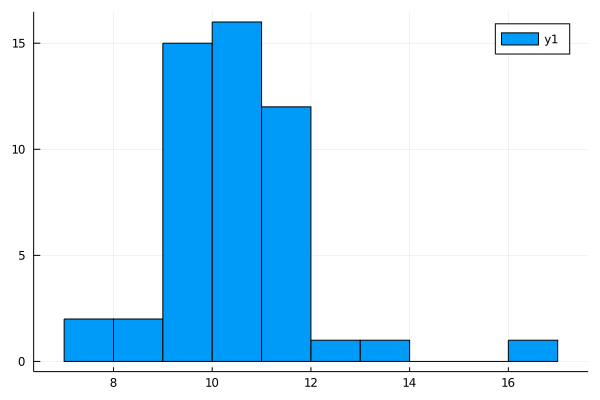

In [8]:
using Plots
histogram(best_k)

In [11]:
count(x -> x == 10, best_k)

16

In [154]:
n = 1000  # number of samples
p = 10000 # number of SNPs
k = 10    # number of causal SNPs per trait
d = Normal
l = canonicallink(d())

# set random seed for reproducibility
Random.seed!(2021)

# simulate `.bed` file with no missing data
x = simulate_random_snparray(undef, n, p)
xla = SnpLinAlg{Float64}(x, model=ADDITIVE_MODEL, center=false, scale=false) 
# xla = randn(n, p)

# intercept is the only nongenetic covariate
z = ones(n)
intercept = 1.0

# simulate response y, true model b, and the correct non-0 positions of b
Y, true_b, correct_position = simulate_random_response(xla, k, d, l, Zu=z*intercept);

In [155]:
@time result = fit_iht(Y, xla, z, d=d(), l=l, k=11, max_iter=200)

****                   MendelIHT Version 1.3.3                  ****
****     Benjamin Chu, Kevin Keys, Chris German, Hua Zhou       ****
****   Jin Zhou, Eric Sobel, Janet Sinsheimer, Kenneth Lange    ****
****                                                            ****
****                 Please cite our paper!                     ****
****         https://doi.org/10.1093/gigascience/giaa044        ****

Running sparse linear regression
Link functin = IdentityLink()
Sparsity parameter (k) = 11
Prior weight scaling = off
Doubly sparse projection = off
Debias = off
Max IHT iterations = 200
Converging when tol < 0.0001:

Iteration 1: loglikelihood = -1674.1707665022236, backtracks = 0, tol = 0.8689180219022307
Iteration 2: loglikelihood = -1592.6419482556962, backtracks = 0, tol = 0.08043396417403254
Iteration 3: loglikelihood = -1571.6432249627637, backtracks = 0, tol = 0.035699559829827344
Iteration 4: loglikelihood = -1555.1960645680808, backtracks = 0, tol = 0.03714161087416787


IHT estimated 11 nonzero SNP predictors and 0 non-genetic predictors.

Compute time (sec):     0.36962103843688965
Final loglikelihood:    -1482.743933641322
SNP PVE:                0.589626185724896
Iterations:             70

Selected genetic predictors:
11×2 DataFrame
 Row │ Position  Estimated_β 
     │ Int64     Float64     
─────┼───────────────────────
   1 │      782    -0.409548
   2 │      901     0.778765
   3 │     1306    -1.29883
   4 │     2710     0.187894
   5 │     3160    -0.806892
   6 │     3715     0.217463
   7 │     4201     0.407596
   8 │     7869     0.169299
   9 │     8041     0.198444
  10 │     8179    -0.128679
  11 │     9700     0.138198

Selected nongenetic predictors:
0×2 DataFrame

In [156]:
# compare estimated vs true beta values
[result.beta[correct_position] true_b[correct_position]]

10×2 Array{Float64,2}:
 -0.409548  -0.402269
  0.778765   0.758756
  0.0        0.729135
 -1.29883   -1.47163
  0.0       -0.172668
 -0.806892  -0.847906
  0.407596   0.296183
  0.0       -0.0034339
  0.0        0.125965
  0.0       -1.24972

In [ ]:
# 4 cores
Random.seed!(2020)
@time mses_new = cv_iht(Y, x, z, d=d(), l=l, parallel=false);

In [60]:
# 4 cores
Random.seed!(2020)
@time mses_new = cv_iht(Y, xla, z, d=d(), l=l, parallel=false);

k = 1, result.beta = [1306]
k = 2, result.beta = [901, 1306]
k = 3, result.beta = [901, 1306, 6886]
k = 4, result.beta = [901, 1306, 3160, 6886]
k = 5, result.beta = [901, 1306, 3160, 4201, 6886]
k = 6, result.beta = [782, 901, 1306, 3160, 4201, 7869]
k = 7, result.beta = [782, 901, 1306, 3160, 4201, 6886, 7869]
k = 8, result.beta = [782, 901, 1306, 3160, 4201, 6886, 7869, 8287]
k = 9, result.beta = [782, 901, 1306, 3160, 3715, 4201, 5751, 6886, 8287]
k = 10, result.beta = [782, 901, 1098, 1306, 3160, 3715, 4201, 5751, 6886, 8287]
k = 11, result.beta = [782, 901, 1306, 1612, 3160, 4201, 4752, 6886, 7541, 7869, 8287]
k = 12, result.beta = [782, 901, 1306, 1612, 3160, 3715, 4201, 5751, 6886, 7541, 7869, 8287]
k = 13, result.beta = [782, 901, 1306, 1612, 3160, 3715, 4201, 4752, 6886, 7523, 7541, 7869, 9700]
k = 14, result.beta = [782, 901, 1306, 1612, 2341, 3160, 4201, 4752, 6886, 7523, 7541, 7869, 8287, 9736]
k = 15, result.beta = [782, 901, 1306, 1612, 1989, 2341, 3160, 4201, 4752, 6886

In [21]:
# 4 cores
Random.seed!(2020)
@time mses_new = cv_iht(Y, xla, z, d=d(), l=l, parallel=true);



Crossvalidation Results:
	k	MSE
	1	518.2617403946808
	2	379.62545459656906
	3	323.0760714431473
	4	283.7949541389568
	5	250.9659367110773
	6	230.66690161722968
	7	219.07336709256512
	8	217.54583143511786
	9	217.44015748198396
	10	219.46436312681257
	11	222.24711247636577
	12	227.19013712219456
	13	231.40334004949085
	14	236.08749234318697
	15	237.97439906266757
	16	245.25297598000628
	17	245.94959965186666
	18	243.42274516309308
	19	249.64405930927845
	20	254.28879222313236

Best k = 9

 11.124177 seconds (17.17 k allocations: 6.126 MiB)


In [176]:
n = 1000  # number of samples
p = 10000 # number of SNPs
k = 10    # number of causal SNPs
r = 2     # number of traits

# set random seed for reproducibility
Random.seed!(2021)

# simulate `.bed` file with no missing data
x = simulate_random_snparray("multivariate_$(r)traits.bed", n, p)
xla = SnpLinAlg{Float64}(x, model=ADDITIVE_MODEL, center=true, scale=true) 

# intercept is the only nongenetic covariate
z = ones(n, 1)
intercepts = [10.0 1.0] # each trait have different intercept

# simulate response y, true model b, and the correct non-0 positions of b
Y, true_Σ, true_b, correct_position = simulate_random_response(xla, k, r, Zu=z*intercepts, overlap=2);

Yt = Matrix(Y')
Zt = Matrix(z')
ktrue = k + count(!iszero, intercepts)
@time result = fit_iht(Yt, Transpose(xla), Zt, k=11, verbose=true)

****                   MendelIHT Version 1.3.3                  ****
****     Benjamin Chu, Kevin Keys, Chris German, Hua Zhou       ****
****   Jin Zhou, Eric Sobel, Janet Sinsheimer, Kenneth Lange    ****
****                                                            ****
****                 Please cite our paper!                     ****
****         https://doi.org/10.1093/gigascience/giaa044        ****

Running sparse Multivariate Gaussian regression
Link functin = IdentityLink()
Sparsity parameter (k) = 11
Prior weight scaling = off
Doubly sparse projection = off
Debias = off
Max IHT iterations = 200
Converging when tol < 0.0001:

Iteration 1: loglikelihood = 215.4892687838203, backtracks = 0, tol = 0.1258803451727764
Iteration 2: loglikelihood = 1400.4415131326584, backtracks = 0, tol = 0.027353391443577676
Iteration 3: loglikelihood = 1485.32487407949, backtracks = 0, tol = 0.007379616806130262
Iteration 4: loglikelihood = 1498.0290279587853, backtracks = 0, tol = 0.01194219


Compute time (sec):     1.0348708629608154
Final loglikelihood:    1514.818382728515
Iterations:             12
Trait 1's SNP PVE:      0.5517175992313121
Trait 2's SNP PVE:      0.6190809967368884

Trait 1: IHT estimated 3 nonzero SNP predictors
3×2 DataFrame
 Row │ Position  Estimated_β 
     │ Int64     Float64     
─────┼───────────────────────
   1 │     5651    -0.200754
   2 │     5797    -1.09966
   3 │     8087     1.27901

Trait 1: IHT estimated 1 non-genetic predictors
1×2 DataFrame
 Row │ Position  Estimated_β 
     │ Int64     Float64     
─────┼───────────────────────
   1 │        1       10.027

Trait 2: IHT estimated 6 nonzero SNP predictors
6×2 DataFrame
 Row │ Position  Estimated_β 
     │ Int64     Float64     
─────┼───────────────────────
   1 │      326     0.331488
   2 │     2110     0.574476
   3 │     5375     1.19453
   4 │     5797     0.501675
   5 │     6015     0.81899
   6 │     6813     1.36762

Trait 2: IHT estimated 1 non-genetic predictors
1×2 Data

In [179]:
Y

1000×2 Array{Float64,2}:
  7.76524   0.753542
 10.4912   -0.796641
 10.4909    4.07845
  8.12064  -2.8017
  7.70636   4.68479
  9.83038   1.8805
  8.91758   1.85881
 10.819    -1.36171
  9.20437   0.0764802
 11.957     2.02683
  9.90901  -3.47313
  6.83158  -0.421095
  8.46284   3.36528
  ⋮        
 11.0223    2.01535
  5.44227   5.34449
  9.82102  -0.952086
  6.13472   5.08911
 11.6637   -2.35605
  7.71781   2.34664
  9.54886  -0.841803
 11.4441   -2.70903
  9.1008   -2.22054
  6.46444   4.16591
 10.2386    5.61415
 13.7244    5.66767

In [158]:
# first beta
β1 = result.beta[1, :]
true_b1_idx = findall(!iszero, true_b[:, 1])
[β1[true_b1_idx] true_b[true_b1_idx, 1]]

4×2 Array{Float64,2}:
 -0.200754  -0.224675
 -1.09966   -1.14044
  0.0       -0.14698
  1.27901    1.25668

In [159]:
# second beta
β2 = result.beta[2, :]
true_b2_idx = findall(!iszero, true_b[:, 2])
[β2[true_b2_idx] true_b[true_b2_idx, 2]]

6×2 Array{Float64,2}:
 0.331488  0.315219
 0.574476  0.609812
 1.19453   1.20121
 0.501675  0.531549
 0.81899   0.808327
 1.36762   1.43455

In [160]:
# non genetic covariates
[result.c intercepts']

2×2 Array{Float64,2}:
 10.027    10.0
  1.03625   1.0

In [161]:
# covariance matrix
[vec(result.Σ) vec(true_Σ)]

4×2 Array{Float64,2}:
  2.48446   2.53934
 -1.83826  -1.85399
 -1.83826  -1.85399
  2.42229   2.41416

In [38]:
Random.seed!(2020)
Yt = Matrix(Y')
Zt = Matrix(z')
@time mses = cv_iht(Yt, Transpose(xla), Zt, path=1:20);



Crossvalidation Results:
	k	MSE
	1	560.8452198435383
	2	473.36416778884137
	3	394.69683489270005
	4	345.9729074156769
	5	294.48164749458044
	6	237.25433730642322
	7	227.51555606212378
	8	212.24365503936244
	9	197.56534911462302
	10	190.75633157112458
	11	189.0135348074002
	12	194.43578718030128
	13	194.17782266465292
	14	194.77726293865328
	15	194.86505581158767
	16	197.05004728641498
	17	198.72923256313942
	18	198.50750103307186
	19	198.76101870046665
	20	196.98072093798976

Best k = 11

193.040649 seconds (88.20 k allocations: 295.995 MiB, 0.03% gc time)


# First simulate multivariate Gaussian traits


With $r$ traits, each sample's phenotype $\mathbf{y}_{i}$ is simulated under

$$\mathbf{y}_{i}^{r \times 1} \sim N(\mathbf{B}^{r \times p}\mathbf{x}_{i}^{p \times 1}, \ \ \Sigma_{r \times r})$$

In [2]:
n = 1000  # number of samples
p = 10000 # number of SNPs
k = 10    # number of causal SNPs
r = 2     # number of traits

# set random seed for reproducibility
Random.seed!(2021)

# simulate `.bed` file with no missing data
x = simulate_random_snparray("multivariate_$(r)traits.bed", n, p)
xla = SnpLinAlg{Float64}(x, model=ADDITIVE_MODEL, center=true, scale=true) 

# intercept is the only nongenetic covariate
z = ones(n, 1)
intercepts = [10.0 1.0] # each trait have different intercept

# simulate response y, true model b, and the correct non-0 positions of b
Y, true_Σ, true_b, correct_position = simulate_random_response(xla, k, r, Zu=z*intercepts, overlap=2);

In [5]:
# save true SNP's position and effect size
open("multivariate_$(r)traits_true_beta.txt", "w") do io
    println(io, "snpID,effectsize")
    for pos in correct_position
        println(io, "snp$pos,", true_b[pos])
    end
end

# create `.bim` and `.bam` files using phenotype
make_bim_fam_files(x, Y, "multivariate_$(r)traits")

# save phenotypes in separate file
open("multivariate_$(r)traits.phen", "w") do io
    println(io, "FID\tIID\tT1\tT2")
    for i in 1:n
        println(io, "$i\t1\t", Y[i, 1], "\t", Y[i, 2])
    end
end

# Run IHT

In [7]:
Yt = Matrix(Y')
Zt = Matrix(z')
ktrue = k + count(!iszero, intercepts)
@time result = fit_iht(Yt, Transpose(xla), Zt, k=11, verbose=true)

****                   MendelIHT Version 1.3.3                  ****
****     Benjamin Chu, Kevin Keys, Chris German, Hua Zhou       ****
****   Jin Zhou, Eric Sobel, Janet Sinsheimer, Kenneth Lange    ****
****                                                            ****
****                 Please cite our paper!                     ****
****         https://doi.org/10.1093/gigascience/giaa044        ****

Running sparse Multivariate Gaussian regression
Link functin = IdentityLink()
Sparsity parameter (k) = 11
Prior weight scaling = off
Doubly sparse projection = off
Debias = off
Max IHT iterations = 100
Converging when tol < 0.0001:

Iteration 1: loglikelihood = 215.4892687838203, backtracks = 0, tol = 0.1258803451727764
Iteration 2: loglikelihood = 1400.4415131326584, backtracks = 0, tol = 0.027353391443577676
Iteration 3: loglikelihood = 1485.32487407949, backtracks = 0, tol = 0.007379616806130262
Iteration 4: loglikelihood = 1498.0290279587853, backtracks = 0, tol = 0.01194219


Compute time (sec):     1.2903869152069092
Final loglikelihood:    1514.818382728515
Iterations:             12
Trait 1's SNP PVE:      0.5517175992313121
Trait 2's SNP PVE:      0.6190809967368884

Trait 1: IHT estimated 3 nonzero SNP predictors
3×2 DataFrame
 Row │ Position  Estimated_β 
     │ Int64     Float64     
─────┼───────────────────────
   1 │     5651    -0.200754
   2 │     5797    -1.09966
   3 │     8087     1.27901

Trait 1: IHT estimated 1 non-genetic predictors
1×2 DataFrame
 Row │ Position  Estimated_β 
     │ Int64     Float64     
─────┼───────────────────────
   1 │        1       10.027

Trait 2: IHT estimated 6 nonzero SNP predictors
6×2 DataFrame
 Row │ Position  Estimated_β 
     │ Int64     Float64     
─────┼───────────────────────
   1 │      326     0.331488
   2 │     2110     0.574476
   3 │     5375     1.19453
   4 │     5797     0.501675
   5 │     6015     0.81899
   6 │     6813     1.36762

Trait 2: IHT estimated 1 non-genetic predictors
1×2 Data

## Check answer

In [8]:
# first beta
β1 = result.beta[1, :]
true_b1_idx = findall(!iszero, true_b[:, 1])
[β1[true_b1_idx] true_b[true_b1_idx, 1]]

4×2 Array{Float64,2}:
 -0.200754  -0.224675
 -1.09966   -1.14044
  0.0       -0.14698
  1.27901    1.25668

In [9]:
# second beta
β2 = result.beta[2, :]
true_b2_idx = findall(!iszero, true_b[:, 2])
[β2[true_b2_idx] true_b[true_b2_idx, 2]]

6×2 Array{Float64,2}:
 0.331488  0.315219
 0.574476  0.609812
 1.19453   1.20121
 0.501675  0.531549
 0.81899   0.808327
 1.36762   1.43455

In [10]:
# non genetic covariates
[result.c intercepts']

2×2 Array{Float64,2}:
 10.027    10.0
  1.03625   1.0

In [11]:
# covariance matrix
[vec(result.Σ) vec(true_Σ)]

4×2 Array{Float64,2}:
  2.48446   2.53934
 -1.83826  -1.85399
 -1.83826  -1.85399
  2.42229   2.41416

In [12]:
# number of causal SNPs recovered
correct_snps = [x[1] for x in correct_position]  # truely causal snps
signif_snps = true_b1_idx ∪ true_b2_idx          # IHT's selected snps
signif_snps ∩ correct_snps

8-element Array{Int64,1}:
 5651
 5797
 6813
 8087
  326
 2110
 5375
 6015

# Test Cross validation

In [14]:
Random.seed!(2020)
Yt = Matrix(Y')
Zt = Matrix(z')
@time mses = cv_iht(Yt, x, Zt);



Crossvalidation Results:
	k	MSE
	1	2888.7160633632484
	2	2563.132216599166
	3	2082.0790076046433
	4	1823.5135405560698
	5	1569.64212209597
	6	1290.814635090646
	7	1168.4492977476905
	8	1112.8787725968111
	9	1030.5676713161718
	10	1033.800473194978
	11	1011.5326080855069
	12	1017.9517382638644
	13	1025.2244799284636
	14	1025.3849393164196
	15	1046.6759600584428
	16	1050.002316385212
	17	1033.9998469176733
	18	1032.590946556068
	19	1045.3508109946156
	20	1043.4650000999131
178.475397 seconds (10.48 M allocations: 917.849 MiB, 0.14% gc time)


In [15]:
argmin(mses)

11

**Conclusion:** After cross validation, IHT finds 10/12 predictors and 8/10 causal SNPs. 

# GEMMA multivariate results

In [9]:
gemma_df = CSV.read("gemma.result.assoc.txt", DataFrame)

# pvalues
pval_wald = gemma_df[!, :p_wald]
pval_lrt = gemma_df[!, :p_lrt]
pval_score = gemma_df[!, :p_score]

# estimated beta
estim_β1 = gemma_df[!, :beta_1]
estim_β2 = gemma_df[!, :beta_2]

# estimated covariance matrix
estim_σ11 = gemma_df[!, :Vbeta_1_1]
estim_σ12 = gemma_df[!, :Vbeta_1_2]
estim_σ22 = gemma_df[!, :Vbeta_2_2];

In [10]:
correct_snps = [x[1] for x in correct_position]  # truely causal snps
signif_snps = findall(x -> x ≤ 0.05/p, pval_lrt) # gemma's selected snps
signif_snps ∩ correct_snps

6-element Array{Int64,1}:
 2110
 5375
 5797
 6015
 6813
 8087

**Conclusion:** GEMMA finds 6/10 causal SNPs

# MV-PLINK

In [25]:
mvplink_df = CSV.read("plink.mqfam.total", DataFrame, delim=' ', ignorerepeated=true)

# pvalues
pval = mvplink_df[!, :P]

# SNPs passing threshold
signif_snps = findall(x -> x ≤ 0.05 / p, pval)
signif_snps ∩ correct_snps

6-element Array{Int64,1}:
 2110
 5375
 5797
 6015
 6813
 8087

**Conclusion:** MV-PLINK finds 6/10 causal SNPs

# Compare with univariate IHT

+ `fit_iht`: ~20 times slower
+ `cv_iht`: ~70 times slower

In [49]:
n = 1000  # number of samples
p = 10000 # number of SNPs
k = 10    # number of causal SNPs per trait
d = Normal
l = canonicallink(d())

# set random seed for reproducibility
Random.seed!(2021)

# simulate `.bed` file with no missing data
x = simulate_random_snparray(undef, n, p)
xla = SnpLinAlg{Float64}(x, model=ADDITIVE_MODEL, center=true, scale=true) 

# intercept is the only nongenetic covariate
z = ones(n)
intercept = 1.0

# simulate response y, true model b, and the correct non-0 positions of b
Y, true_b, correct_position = simulate_random_response(xla, k, d, l, Zu=z*intercept);

In [50]:
@time result = fit_iht(Y, xla, z, d=d(), l=l, k=11)

****                   MendelIHT Version 1.4.0                  ****
****     Benjamin Chu, Kevin Keys, Chris German, Hua Zhou       ****
****   Jin Zhou, Eric Sobel, Janet Sinsheimer, Kenneth Lange    ****
****                                                            ****
****                 Please cite our paper!                     ****
****         https://doi.org/10.1093/gigascience/giaa044        ****

Running sparse linear regression
Link functin = IdentityLink()
Sparsity parameter (k) = 11
Prior weight scaling = off
Doubly sparse projection = off
Debias = off
Debias = off
Max IHT iterations = 100
Converging when tol < 0.0001:

Iteration 1: loglikelihood = -1577.170794759688, backtracks = 0, tol = 0.609864675283163
Iteration 2: loglikelihood = -1484.8568136206177, backtracks = 0, tol = 0.1269955771967065
Iteration 3: loglikelihood = -1472.9529635904933, backtracks = 0, tol = 0.05823372413927707
Iteration 4: loglikelihood = -1472.5366421393842, backtracks = 1, tol = 0.00450895


IHT estimated 10 nonzero SNP predictors and 1 non-genetic predictors.

Compute time (sec):     0.06683206558227539
Final loglikelihood:    -1472.3905989669602
Iterations:             10

Selected genetic predictors:
10×2 DataFrame
 Row │ Position  Estimated_β 
     │ Int64     Float64     
─────┼───────────────────────
   1 │      782    -0.437828
   2 │      901     0.747956
   3 │     1204     0.691327
   4 │     1306    -1.42505
   5 │     1655    -0.19456
   6 │     3160    -0.861591
   7 │     3936    -0.147235
   8 │     4201     0.338606
   9 │     4402    -0.126472
  10 │     6879    -1.21895

Selected nongenetic predictors:
1×2 DataFrame
 Row │ Position  Estimated_β 
     │ Int64     Float64     
─────┼───────────────────────
   1 │        1      1.02016

In [41]:
# compare estimated vs true beta values
[result.beta[correct_position] true_b[correct_position]]

10×2 Array{Float64,2}:
 -0.437828  -0.402269
  0.747956   0.758756
  0.691327   0.729135
 -1.42505   -1.47163
 -0.19456   -0.172668
 -0.861591  -0.847906
  0.338606   0.296183
  0.0       -0.0034339
  0.0        0.125965
 -1.21895   -1.24972

### Cross validation timing

In [92]:
# 1 cores
Random.seed!(2020)
@time cv_iht(Y, x, z);



Crossvalidation Results:
	k	MSE
	1	1221.686764265696
	2	864.1553085156108
	3	661.6430376327284
	4	516.2679723147669
	5	418.2721191658746
	6	342.7931325462592
	7	303.15938053956916
	8	276.6241892508097
	9	278.29180795455045
	10	280.31878745464377
	11	282.10757732881564
	12	285.1294156734012
	13	293.16875008847467
	14	297.43739905389987
	15	296.17300065041906
	16	307.7814278347698
	17	302.0113818893564
	18	312.70262374274137
	19	309.87367962700966
	20	315.6750311115386
  4.315330 seconds (9.35 M allocations: 332.277 MiB, 1.12% gc time)


# More complicated univariate traits

Let's simulate $10$ causal SNPs where genetics explain 60% of heritability for $2$ traits. The univariate model is:

$$\mathbf{y}_{n \times 1} \sim N(\mathbf{X}_{n \times p}\mathbf{\beta}_{p \times 1} \ , \ \sigma_g^2 \Phi_{n \times n} + \sigma_e^2 \mathbf{I}_{n}).$$

where $\Phi$ is the GRM and $\sigma_g^2 = 0.6, \sigma_e^2 = 0.4$. 

In [197]:
"""
k = Number of causal SNPs
p = Total number of SNPs
traits = Number of traits (phenotypes)
overlap = number of causal SNPs shared in each trait
"""
function simulate_random_beta(k::Int, p::Int, traits::Int; overlap::Int=0)
    true_b = zeros(p, traits)
    if overlap == 0
        causal_snps = sample(1:(traits * p), k, replace=false)
        true_b[causal_snps] = randn(k)
    else
        shared_snps = sample(1:p, overlap, replace=false)
        weight_vector = aweights(1 / (traits * (p - overlap)) * ones(traits * p))
        for i in 1:traits
            weight_vector[i*shared_snps] .= 0.0 # avoid sampling from shared snps
        end
        @assert sum(weight_vector) ≈ 1.0
        # simulate β for shared predictors
        for i in 1:traits
            true_b[shared_snps, i] = randn(overlap)
        end
        # simulate β for none shared predictors
        nonshared_snps = sample(1:(traits * p), weight_vector, k - traits * overlap, replace=false)
        true_b[nonshared_snps] = randn(k - traits * overlap)
    end

    return true_b
end

simulate_random_beta

In [267]:
n = 1000  # number of samples
p = 10000 # number of SNPs
k = 10    # number of causal SNPs per trait
d = Normal
l = canonicallink(d())

# set random seed for reproducibility
Random.seed!(2021)

# simulate `.bed` file with no missing data
x = simulate_random_snparray(undef, n, p)
xla = SnpLinAlg{Float64}(x, model=ADDITIVE_MODEL, center=true, scale=true) 

# simulate true_b with 1 phenotype
b = simulate_random_beta(k, p, 1)

# intercept is the only nongenetic covariate
z = ones(n)
intercept = 1.0

# between sample covariance is identity + GRM (2 times because in SnpArrays grm is halved)
Φ = 2grm(x)
I_n = Matrix{Float64}(I, size(Φ))
σg = 0.6
σe = 0.4
V = σg * Φ + σe * I_n;

# simulate response y
mvn = MvNormal(vec(intercept * z + xla * b), V)
y = rand(mvn);

In [268]:
ktrue = k + count(!iszero, intercept)
@time result = fit_iht(y, xla, z, k=ktrue, max_iter=200)

****                   MendelIHT Version 1.3.3                  ****
****     Benjamin Chu, Kevin Keys, Chris German, Hua Zhou       ****
****   Jin Zhou, Eric Sobel, Janet Sinsheimer, Kenneth Lange    ****
****                                                            ****
****                 Please cite our paper!                     ****
****         https://doi.org/10.1093/gigascience/giaa044        ****

Running sparse linear regression
Link functin = IdentityLink()
Sparsity parameter (k) = 11
Prior weight scaling = off
Doubly sparse projection = off
Debias = off
Max IHT iterations = 200
Converging when tol < 0.0001:

Iteration 1: loglikelihood = -1627.0353462544151, backtracks = 0, tol = 0.6924353417126095
Iteration 2: loglikelihood = -1420.1638948810214, backtracks = 0, tol = 0.23769360612297397
Iteration 3: loglikelihood = -1406.552555178033, backtracks = 0, tol = 0.07456091670768471
Iteration 4: loglikelihood = -1405.9717536588919, backtracks = 0, tol = 0.007850378616075855



IHT estimated 10 nonzero SNP predictors and 1 non-genetic predictors.

Compute time (sec):     0.034310102462768555
Final loglikelihood:    -1405.9651489743871
SNP PVE:                0.9024422743420005
Iterations:             7

Selected genetic predictors:
10×2 DataFrame
 Row │ Position  Estimated_β 
     │ Int64     Float64     
─────┼───────────────────────
   1 │      329     0.501429
   2 │     1438     0.852922
   3 │     5797    -1.1783
   4 │     6307     1.5088
   5 │     6813    -0.158366
   6 │     7152     1.07684
   7 │     8070     0.772066
   8 │     8739     1.38536
   9 │     9138    -0.586787
  10 │     9180     0.563219

Selected nongenetic predictors:
1×2 DataFrame
 Row │ Position  Estimated_β 
     │ Int64     Float64     
─────┼───────────────────────
   1 │        1      1.01532

In [271]:
# compare estimated vs true beta values
correct_position = findall(!iszero, b)
[result.beta[correct_position] b[correct_position]]

10×2 Array{Float64,2}:
  0.501429   0.531549
  0.852922   0.882913
 -1.1783    -1.14044
  1.5088     1.43455
 -0.158366  -0.14698
  1.07684    1.11302
  0.772066   0.812423
  1.38536    1.37084
 -0.586787  -0.589568
  0.563219   0.622075

# More complicated multivariate traits

With $r$ traits, the multivariate analog is:

$$\mathbf{Y}_{r \times n} \sim \text{MatrixNormal}(\mathbf{B}_{r \times p}\mathbf{X}_{p \times n}, \ \ \Sigma_{r \times r} , \ \ \sigma_g^2\Phi_{n \times n} + \sigma_e^2 \mathbf{I}_{n \times n})$$

where $\Sigma_{r \times r}$ is the row covariance matrix, and $\sigma_g^2\Phi_{n \times n} + \sigma_e^2 \mathbf{I}_{n \times n}$ is the column covariance matrix. Again, $\Phi$ is the GRM and $\sigma_g^2 = 0.6, \sigma_e^2 = 0.4$. 

In [308]:
n = 1000  # number of samples
p = 10000 # number of SNPs
k = 20    # number of causal SNPs
r = 2     # number of traits

# set random seed for reproducibility
Random.seed!(2021)

# simulate `.bed` file with no missing data
x = simulate_random_snparray("multivariate_$(r)traits.bed", n, p)
xla = SnpLinAlg{Float64}(x, model=ADDITIVE_MODEL, center=true, scale=true) 

# intercept is the only nongenetic covariate
z = ones(n, 1)
intercepts = [10.0 1.0] # each trait have different intercept

# simulate β
B = simulate_random_beta(k, p, r, overlap=2)

# between trait covariance matrix
Σ = random_covariance_matrix(r)

# between sample covariance is identity + GRM (2 times because in SnpArrays grm is halved)
Φ = 2grm(x)
σg = 0.6
σe = 0.4
V = σg * Φ + σe * I

# simulate y using TraitSimulations.jl
# VCM_model = VCMTrait(z, intercepts, x, B, [Σ], [V]) #https://github.com/OpenMendel/TraitSimulation.jl/blob/6d1f09c7332471a74b4dd6c8ef2d2b95a96c585c/src/modelframework.jl#L159
# Y = simulate(VCM_model)

# simulate using naive model
μ = z * intercepts + xla * B
Y = rand(MatrixNormal(μ', Σ, V))

2×1000 Array{Float64,2}:
 3.37003  11.076    6.41795  6.824    …  4.97186  8.53641  6.7019  10.2617
 2.60801   4.22722  3.58501  2.70536     3.24736  1.00095  3.2774  -1.39142

## Run IHT 

In [309]:
# Yt = Matrix(Y')
Zt = Matrix(z')
ktrue = k + count(!iszero, intercepts)
@time result = fit_iht(Y, Transpose(xla), Zt, k=ktrue, verbose=true)

****                   MendelIHT Version 1.3.3                  ****
****     Benjamin Chu, Kevin Keys, Chris German, Hua Zhou       ****
****   Jin Zhou, Eric Sobel, Janet Sinsheimer, Kenneth Lange    ****
****                                                            ****
****                 Please cite our paper!                     ****
****         https://doi.org/10.1093/gigascience/giaa044        ****

Running sparse Multivariate Gaussian regression
Link functin = IdentityLink()
Sparsity parameter (k) = 22
Prior weight scaling = off
Doubly sparse projection = off
Debias = off
Max IHT iterations = 200
Converging when tol < 0.0001:

Iteration 1: loglikelihood = -475.2988214368961, backtracks = 0, tol = 0.12966924327121895
Iteration 2: loglikelihood = 883.6693113723943, backtracks = 0, tol = 0.03593835876755371
Iteration 3: loglikelihood = 1149.365077358489, backtracks = 0, tol = 0.004279279206162846
Iteration 4: loglikelihood = 1171.8910317942218, backtracks = 0, tol = 0.0188153


Compute time (sec):     1.816992998123169
Final loglikelihood:    1265.0922537755628
Iterations:             21
Trait 1's SNP PVE:      0.835844876211814
Trait 2's SNP PVE:      0.46118893066249433

Trait 1: IHT estimated 12 nonzero SNP predictors
12×2 DataFrame
 Row │ Position  Estimated_β 
     │ Int64     Float64     
─────┼───────────────────────
   1 │      200   -1.1852
   2 │      600    1.01931
   3 │     1756   -0.0975711
   4 │     3638   -0.713653
   5 │     4322   -0.309832
   6 │     4678    1.59124
   7 │     5298   -0.614442
   8 │     5797   -1.13881
   9 │     6136    0.798066
  10 │     7091    0.229139
  11 │     7325   -0.372033
  12 │     7360   -0.0903845

Trait 1: IHT estimated 1 non-genetic predictors
1×2 DataFrame
 Row │ Position  Estimated_β 
     │ Int64     Float64     
─────┼───────────────────────
   1 │        1       10.024

Trait 2: IHT estimated 8 nonzero SNP predictors
8×2 DataFrame
 Row │ Position  Estimated_β 
     │ Int64     Float64     
─────┼──

In [310]:
# first beta
β1 = result.beta[1, :]
true_b1_idx = findall(!iszero, B[:, 1])
[β1[true_b1_idx] B[true_b1_idx, 1]]

11×2 Array{Float64,2}:
 -1.1852    -1.20245
  1.01931    1.00062
 -0.713653  -0.735789
 -0.309832  -0.265599
  1.59124    1.58324
 -0.614442  -0.648652
 -1.13881   -1.14044
  0.798066   0.782584
  0.0       -0.14698
  0.229139   0.231528
 -0.372033  -0.383864

In [311]:
# second beta
β2 = result.beta[2, :]
true_b2_idx = findall(!iszero, B[:, 2])
[β2[true_b2_idx] B[true_b2_idx, 2]]

9×2 Array{Float64,2}:
  0.0        0.125648
  0.557493   0.602347
 -0.978967  -0.954644
  0.0        0.0161438
  0.50544    0.531549
  1.10605    1.43455
 -1.09852   -1.08864
  0.88801    0.997248
 -1.55919   -1.47439

In [312]:
# non genetic covariates
[result.c intercepts']

2×2 Array{Float64,2}:
 10.024     10.0
  0.987092   1.0

In [301]:
# covariance matrix
[vec(result.Σ) vec(Σ)]

4×2 Array{Float64,2}:
  1.79311   1.79198
 -3.15315  -3.07031
 -3.15315  -3.07031
  7.96981   7.74209